# CALB MeOH

In [1]:
#Import modules
import pyemma
import os
import glob
import pandas as pd
import numpy as np
import sys
import importlib

#Path were classes are stored
base_path='/media/dataHog/hca/'
sys.path.append(base_path)
sys.path.append(base_path+'proLig/')

import main
import plots
import tools

importlib.reload(main)

<module 'main' from '/media/dataHog/hca/proLig/main.py'>

## Project definition

A system is defined using the *Project* class.
Needs to specify the *workdir* (e.g. location in DataHog) and *parent_folder* (e.g. calb-MeOH).

Note: The NAC array *nac_i* for the 100ns to 200ns (-1) has been previously calculated for each replicate.


TODO: Read from XML file.

In [2]:
importlib.reload(main)
#workdir=base_path+"calb-MeOH/"

workdir=base_path+'proLig_CalB-Methanol'
results=workdir+"/project_results"

tools.Functions.fileHandler([workdir, results], confirmation=False)


protein=['calb']
ligand=['MeOH']
concentrations=['50mM', '150mM', '300mM', '600mM', '1M', '2.5M', '5.5M']
#concentrations=['50mM']

project=main.Project(title='CalB-Methanolysis', hierarchy=('protein', 'ligand', 'parameter'), workdir=workdir, 
                     parameter=concentrations, replicas=10, timestep=5,
                     protein=protein, ligand=ligand, results=results)


project_systems=project.setSystems()

for property, value in project.__dict__.items():
    print(f'{property}: {value}')

workdir: /media/dataHog/hca/proLig_CalB-Methanol
title: CalB-Methanolysis
hierarchy: ('protein', 'ligand', 'parameter')
parameter: ['50mM', '150mM', '300mM', '600mM', '1M', '2.5M', '5.5M']
replicas: 10
protein: ['calb']
ligand: ['MeOH']
timestep: 5
results: /media/dataHog/hca/proLig_CalB-Methanol/project_results
systems: {'calb-MeOH-50mM-1': <main.System object at 0x7fd0cecc8910>, 'calb-MeOH-50mM-2': <main.System object at 0x7fd05adcb190>, 'calb-MeOH-50mM-3': <main.System object at 0x7fd0cecc8950>, 'calb-MeOH-50mM-4': <main.System object at 0x7fd0cecc8990>, 'calb-MeOH-50mM-5': <main.System object at 0x7fd0cecc89d0>, 'calb-MeOH-50mM-6': <main.System object at 0x7fd0cecc8a50>, 'calb-MeOH-50mM-7': <main.System object at 0x7fd0cecc8a90>, 'calb-MeOH-50mM-8': <main.System object at 0x7fd0cecc8ad0>, 'calb-MeOH-50mM-9': <main.System object at 0x7fd0cecc8b10>, 'calb-MeOH-50mM-10': <main.System object at 0x7fd0cecc8a10>, 'calb-MeOH-150mM-1': <main.System object at 0x7fd0cecc8b50>, 'calb-MeOH-150

## Featurization

Define feature to be used for MSM construction. Uses class *Features* containing the featurization option. 

Feature *nac* has been pre-calculated and .npy file is loaded by pyEMMA.

Feature *dist* uses pyEMMA to calculate t.he distance between two selections (dist1, dist2). Current case measures the distance between carbonyl carbon of acetylated serine and the hydroxyl oxygen of methanol (resname SEA and index 1526 --- OA) using a *stride* defined above.

In [3]:
importlib.reload(main)
features={}

features['nac']=main.Features(project_systems, results=results).nac()

#for system in project_systems:
#    features['nac']=main.Features(system).nac()
    
#features['dist']=main.Features(project).dist('resname MeOH and name OA', 'resname SEA and index 1526', stride, skip_frames=20000)

Display the histogram of *features*. To save memory, only at this point pyEMMA is used to load the actual files *feature[1]*

## Discretization

The *features* are discretized based on selected discretization scheme. Three discretization schemes are curreltly available:  **combinatorial**. 


**Combinatorial** Discretize, for each frame, which combinations of regions are occupied by all ligands in the system (one state per frame)

Set the region boundaries *regions*. The minimum (0) and maximum (max) value are implicit.\
E.g.: regions (4.5, 10, 24) corresponds to: \
region 1 -  (0, 4.5( \
region 2 - (4.5, 10( \
region 3 - (10, 24( \
region 4 - (24, max( \
\
Labels *labels* of each region are optional but recommended (otherwise reverts to numerical). Number of *labels* is plus one the number of defined *regions*.

l1          calb                               ...                           \
l2          MeOH                               ...                            
l3          50mM                               ... 5.5M                       
l4             1  2  3   4   5  6  7  8  9 10  ...    1   2   3   4   5   6   
Frame index                                    ...                            
0              3  3  1   7   3  3  1  3  3  1  ...   31  15  15  15  27  27   
1              3  3  1   7   3  3  1  3  3  1  ...   31  15  15  15  27  27   
2              3  3  1  11   3  3  1  3  3  1  ...   31  15  15  11  31  27   
3              3  3  1  11   3  3  1  1  3  1  ...   31  15  15  15  31  27   
4              3  3  1   7   3  3  1  3  3  1  ...   31  15  31  15  31  15   
...          ... .. ..  ..  .. .. .. .. .. ..  ...  ...  ..  ..  ..  ..  ..   
19995          1  3  1   3   7  1  3  1  1  3  ...   31  15  31  15  31  31   
19996          1  1  1   3   7  1  3  1  1  3  ...  

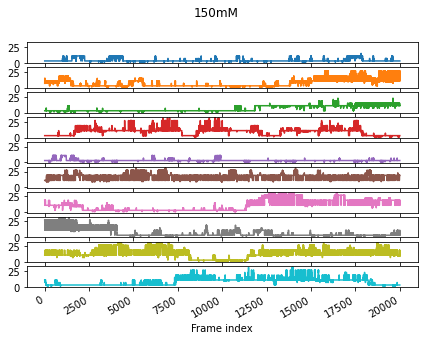

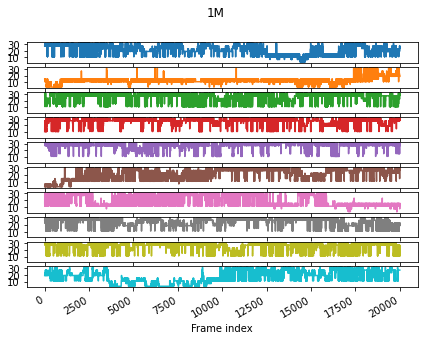

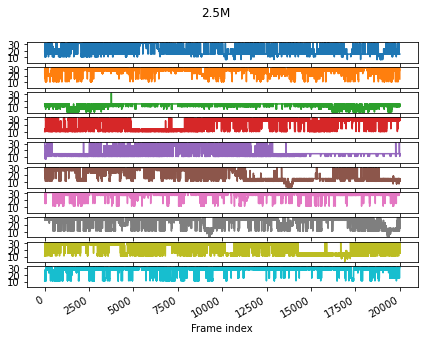

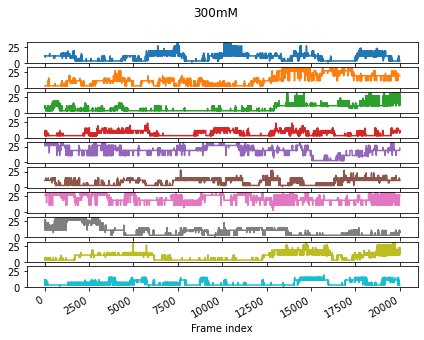

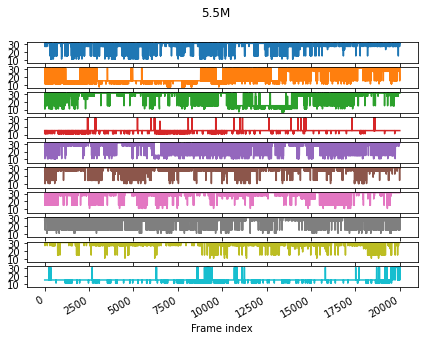

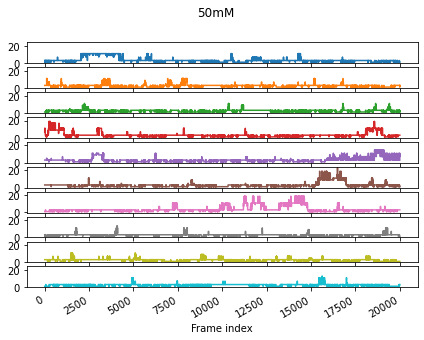

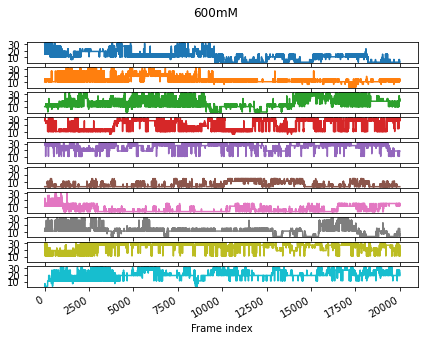

In [4]:
importlib.reload(main)

shells=[4.5, 10, 12, 24]
labels=['A', 'P', 'E', 'S', 'B'] 

discretize=main.Discretize(project_systems, feature=features['nac'], results=results)
combinatorial=discretize.combinatorial(shells, labels=labels)

print(combinatorial)

#TODO: Make a proper function.
sampled_states_trj={}

for trajectory in combinatorial.columns:
    sampled_states_trj[trajectory]=pd.unique(combinatorial[trajectory].values.flatten()) 

discretize.plot(combinatorial)

## Trajectory operations

Initiate the trajectory object, which will be used to make further actions.

In [5]:
importlib.reload(main)
trajectories=main.Trajectory(project_systems, results=results)

### Extract state frames

Define the frames belonging to a set of states across all *trajectories*. A dataframe of discretized trajectories must be given. 

In [6]:

stateLabels=['PSB', 'PEB', 'PESB']
states=[11, 13, 15]

extracted_frames=trajectories.extractFrames_by_iterable(combinatorial, iterable=states, feature='nac')

## Density Maps

NOTE: Compute intensive, using previously stored files.

In [7]:
#of extracted frames

densities=trajectories.DensityMap_frames(frames=extracted_frames, level=2)

Level: 150mM
	Iterable: 11
	Density file found: /media/dataHog/hca/proLig_CalB-Methanol/project_results/superposed_150mM-it11-s1-Molar.dx
	Iterable: 13
	Density file found: /media/dataHog/hca/proLig_CalB-Methanol/project_results/superposed_150mM-it13-s1-Molar.dx
	Iterable: 15
	Density file found: /media/dataHog/hca/proLig_CalB-Methanol/project_results/superposed_150mM-it15-s1-Molar.dx
Level: 1M
	Iterable: 11
	Density file found: /media/dataHog/hca/proLig_CalB-Methanol/project_results/superposed_1M-it11-s1-Molar.dx
	Iterable: 13
	No frames found.
	Iterable: 15
	Density file found: /media/dataHog/hca/proLig_CalB-Methanol/project_results/superposed_1M-it15-s1-Molar.dx
Level: 2.5M
	Iterable: 11
	Density file found: /media/dataHog/hca/proLig_CalB-Methanol/project_results/superposed_2.5M-it11-s1-Molar.dx
	Iterable: 13
	No frames found.
	Iterable: 15
	Density file found: /media/dataHog/hca/proLig_CalB-Methanol/project_results/superposed_2.5M-it15-s1-Molar.dx
Level: 300mM
	Iterable: 11
	Densit

## Visualize trajectories

In [ ]:
full_densities=trajectories.DensityMap_fullTraj(level=2, filtered=True, stride=5)

In [ ]:
full_densities

In [6]:
def viewer():
    import nglview
    stride=1
    c=input('Value of parameter: ')
    it=input('Value of iterable: ')
    
    base_name='./superposed'
    os.chdir(results)
    print(f'{base_name}_{c}_it{it}.pdb')
    view=nglview.show_file(f'{base_name}_{c}-it{it}-s{stride}.pdb')
    view.add_component(f'{base_name}_{c}-it{it}-s{stride}-Molar.dx')
    view.add_component(f'{base_name}_{c}-it{it}-s{stride}.xtc')
    view
    
    return view

viewer()

Value of parameter:  50mM
Value of iterable:  11


./superposed_50mM_it11.pdb


NGLWidget()

In [48]:
    def viewer(base_name='superposed', stride=1):
        
        import nglview
        
        c=input('Value of parameter: ')
        it=input('Value of iterable: ')
    
        base_name=f'{results}/{base_name}'
        print(f'{base_name}_{c}-it{it}-s{stride}.xtc')

        view=nglview.show_file(f'{base_name}_{c}-it{it}-s{stride}.pdb')
        view.add_component(f'{base_name}_{c}-it{it}-s{stride}-Molar.dx')
        #view.add_component(f'{base_name}_{c}-it{it}-s{stride}.xtc')
        #view.clear_representations()
        #view.add_representation('cartoon')
        #view.add_representation('licorice', selection='not hydrogen')
        view
        return view
viewer()

Value of parameter:  50mM
Value of iterable:  11


/media/dataHog/hca/proLig_CalB-Methanol/project_results/superposed_50mM-it11-s1.xtc


NGLWidget()

In [32]:
importlib.reload(main)
viewer=main.Visualize(results)
viewer=viewer.viewer()

Value of parameter:  150mM
Value of iterable:  11


/media/dataHog/hca/proLig_CalB-Methanol/project_results/superposed_150mM-it11-s1.xtc


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xcb in position 3: invalid continuation byte

In [ ]:
plots.plot_feature_histogram(systems_featurized_nac)

#for name, features in features_dict.items():
#    plots.plot_feature_histogram(concentrations, name, features, results)

for feature, parameter in features.items():
    print(feature)
    for value, data in parameter.items():
        print(value)
        print(data)


Plot histograms of discretized features.

In [ ]:

for scheme, v in disc.items():
    for feature, parameter_dict in v.items():
        for parameter, values in parameter_dict.items():
            data=np.load(values['discretized'][0]).flatten()
            minimum, maximum=np.around(np.min(data)), np.around(np.max(data))
            plt.hist(data, alpha=0.5, bins=np.arange(minimum, maximum), label=parameter)
                
        if scheme == 'combinatorial':
            label_names=base.Functions.sampledStateLabels(regions, labels=labels)
            positions=np.arange(0, len(label_names))
            plt.xticks(positions+0.5, label_names, rotation=70)      
        plt.legend()
        plt.xlabel('State Index')
        plt.ylabel('Counts')
        plt.title(f'{scheme}-{feature}')
        plt.savefig(f'{results}/discretization_{scheme}_histogram-{feature}.png', bbox_inches='tight', dpi=600)
        plt.show()

## Markov State Model

A dictionary of MSM *msm_dict* is created. Each MSM is identified by the corresponding discretization *scheme*, the *feature* and *parameter* as a key of *msm_dict*. The corresponding values themselves a dictionary holding the calculated properties of the MSM. The instance of *classes.MSM* is *instance*.

TODO: Fetch prot and mol directly from System class.

In [ ]:
msm_dict={}

protein, ligand, timestep=system.getProperties('protein', 'ligand', 'timestep')


for scheme, v in disc.items():
    for feature, parameter_dict in v.items():
        for parameter, values in parameter_dict.items():
            msm_dict[f'{scheme}-{feature}-{parameter}']={'instance': base.MSM(scheme, feature, parameter, 
                                                                              values, protein, ligand, timestep, results=results)}
            


**Implied Time Scales**

Calculate the Implied Time Scales for each MSM object using the *ITS* function. This function uses the pyEMMA function (pyemma.msm.its). The default array of lags can be used by pyEMMA, but here the values are provided by *lags*.

The function checks for previously calculated ITS plots by checking the presence of the corresponding *png* file in the *results* folder. 

The file path to the generated ITS image is stored in the *msm_dict* (2nd position)

In [ ]:
lags=[1, 2, 5, 10, 20, 40, 100, 500, 1000, 2000, 5000]

for name, model in msm_dict.items():
    model['its']=model['instance'].ITS(lags)
            

**Bayesian MSM**
Calculation of Bayesian MSM is made here. A lag time must be defined for each discretization *scheme-feature-parameter* combination.

In [ ]:
importlib.reload(base)
lag={}

minimum={}
minimum['nac']={'50mM':500, '150mM':1000, '300mM':1000, '600mM':2000, '1M':1000, '2.5M':2000, '5.5M':2000}
minimum['dist']={'50mM':1000, '150mM':1000, '300mM':2000, '600mM':2000, '1M':2000, '2.5M':2000, '5.5M':2000}
lag['minimum']=minimum

single={}
single['nac']={'50mM':None, '150mM':None, '300mM':None, '600mM':None, '1M':200, '2.5M':None, '5.5M':2000}
single['dist']={'50mM':None, '150mM':None, '300mM':None, '600mM':None, '1M':1000, '2.5M':None, '5.5M':None}
lag['single']=single

combinatorial={}
combinatorial['nac']={'50mM':200, '150mM':2000, '300mM':1000, '600mM':5000, '1M':2000, '2.5M':2000, '5.5M':2000}
combinatorial['dist']={'50mM':200, '150mM':200, '300mM':200, '600mM':500, '1M':500, '2.5M':1000, '5.5M':1000}
lag['combinatorial']=combinatorial

for name, model in msm_dict.items():
    print(name)
    model['bayesMSM']=model['instance'].bayesMSM(lag)

**Stationary Distribution**

Stationary distribution is calculated for each available model. Model instance accessed by *model(2)*

In [ ]:
pi=pd.DataFrame()

for name, model in msm_dict.items():
    print(name)
    pi_model=model['instance'].stationaryDistribution(model['bayesMSM'])
    pi=pd.concat([pi, pi_model], axis=1)

pi.to_csv(f'{results}/stationary_distributions.csv')

for scheme, v in disc.items():
    for feature in v.keys(): 
        if scheme == 'combinatorial':
            statdist_df=pi.xs((scheme, feature), axis=1).dropna(how='all')
            statdist_df.plot(kind='bar')
            label_names=base.Functions.sampledStateLabels(regions, sampled_states=statdist_df.index.values, labels=labels)
            positions=np.arange(0, len(label_names))
            plt.xticks(positions, label_names, rotation=70)
            plt.xlabel('Combinatorial States')
        else:
            pi.xs((scheme, feature), axis=1).plot(linestyle='-', marker='o') #kind='bar', stacked=True)
            plt.xlabel('State Index')
        plt.yscale('log')
        plt.ylabel('Stationary Distribution')
        plt.title(f'Discretization: {scheme}\nFeature: {feature}')
        plt.savefig(f'{results}/stationary_distribution-{scheme}-{feature}.png', bbox_inches='tight', dpi=600)
        plt.show()

**Flux**

Calculate the flux between set of source states *A_source* and set of sink states *B_sink*. 

In [ ]:
importlib.reload(base)
importlib.reload(plots)

flux_df=pd.DataFrame()
committor_df=pd.DataFrame()
pathway_df=pd.DataFrame()

for name,model in msm_dict.items():
    flux_model, committor_model, pathway_model=base.MSM.flux(name, model['bayesMSM'], parameter_scalar=parameter_scalar, 
                                regions=regions, labels=labels, 
                                A_source=['B', 'SB', 'ESB'],
                                B_sink=['AB', 'ASB', 'AEB', 'AESB', 'APB', 'APSB', 'APEB', 'APESB'],
                                top_pathways=1)
        
    flux_df=pd.concat([flux_df, flux_model], axis=0)
    committor_df=pd.concat([committor_df, committor_model], axis=0)
    pathway_df=pd.concat([pathway_df, pathway_model], axis=0)

    
plots.plot_pathways(pathway_df, ligand, results)
plots.plot_flux(flux_df, ligand, results)
plots.plot_committor(committor_df, ligand, results, regions, labels)


pathway_df.to_csv(f'{results}/pathways.csv')
flux_df.to_csv(f'{results}/net_fluxes.csv') 
committor_df.to_csv(f'{results}/committors.csv')





**Mean First Passage Times**

Calculate the MFPTs between all states.

k$_{on}$=1/MFPTxC, where C is concentration in Molar \
k$_{off}$=1/MFPT


Stores the resutls in the *mfpt* dataframe

**Warning**: This step takes a long time to perform. The following cell loads a pre-calculated *mfpt* dataframe.

In [ ]:
importlib.reload(base)
mfpt_df=pd.DataFrame()

for name, model in msm_dict.items():
    print(name)
    mfpt=model['instance'].MFPT(model['bayesMSM'])
    mfpt_df=pd.concat([mfpt_df, mfpt], axis=0)

mfpt_df.to_csv(f'{results}/mfpt.csv')



In [ ]:
importlib.reload(base)
importlib.reload(plots)

mfpt_df=pd.read_csv(f'{results}/mfpt.csv', index_col=[0,1,2], header=[0,1,2])

schemes=mfpt_df.index.unique(level='Scheme')
features=mfpt_df.index.unique(level='feature')
states=mfpt_df.index.unique(level='state_source')
parameters=mfpt_df.columns.get_level_values(level='parameter').unique()

error=0.2

for scheme in schemes:
    print('Scheme: ', scheme)
    for feature in features:
        print('Feature: ', feature)
        plots.plot_MFPT(mfpt_df, scheme, feature, concentrations, error=error, labels=labels, regions=regions)
        plt.savefig(f'{results}/mfpt_{scheme}-{feature}-{error}.png', bbox_inches='tight', dpi=600)
        plt.show()


**Process Trajectories**
